# Model V1

In [1]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

Make reproducible

In [2]:
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

# Load the images

In [3]:
from torch.utils.data import Dataset
from skimage import io, transform
from PIL import Image

In [4]:
import pandas as pd
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.images = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir+'/'+self.images.iloc[idx, 0]
        
        with Image.open(img_name) as image:
            if self.transform:
                image = self.transform(image)

        return (image, self.images.iloc[idx, 1])

In [5]:
image_folder = ImageDataset(csv_file='data/train.csv', root_dir='data/train_images', 
                           transform=transforms.Compose([transforms.Resize(200), 
                                                         transforms.ToTensor(),
                                                         #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                                        ]))

In [6]:
len(image_folder)

21397

In [7]:
img1, class1 = image_folder[0]
img1.shape

torch.Size([3, 200, 266])

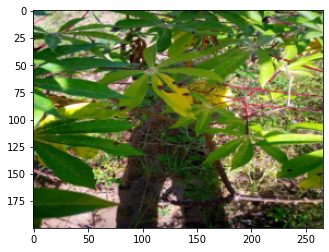

In [8]:
from matplotlib.pyplot import imshow
from torchvision import transforms
imshow(transforms.ToPILImage()(img1))

Add normalization

In [9]:
image_folder = ImageDataset(csv_file='data/train.csv', root_dir='data/train_images', 
                           transform=transforms.Compose([transforms.Resize(200), 
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                                        ]))

## Define train and testsets

In [10]:
from torch.utils.data import random_split
N = len(image_folder)
train_dataset, test_dataset = random_split(image_folder, [int(N*0.8)+1, int(N*0.2)])

In [11]:
data_loader = torch.utils.data.DataLoader(train_dataset
    ,batch_size=25
    ,shuffle=True
    ,num_workers=2                                      
)

## Define the network

In [12]:
sample = next(iter(image_folder))
image, label = sample 
image.shape

torch.Size([3, 200, 266])

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=24 * 12 * 8, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=5)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #print(t.shape)
        t = t.reshape(-1, 24 * 12 * 8)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.out(t)
        t = F.softmax(t, dim=1)
    
        return t

In [14]:
network = Network()
network.eval()

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=5, bias=True)
)

## Train the network

In [15]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters(), lr=0.05)
from evaluate import get_num_correct

In [16]:
import time

for epoch in range(10):
    total_loss = 0
    total_correct = 0
    N = 0
    start_time = time.time()
    for batch in data_loader:
        images, labels = batch 
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        N += len(preds)
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    print(
    "epoch:", epoch, 
    "accuracy:", round(100 * total_correct/N), '%',
    "total_correct", total_correct,
    "loss:", total_loss,
    "duration:", time.time()-start_time, 's'
    )

epoch: 0 accuracy: 61 % total_correct 10462 loss: 885.8821585774422 duration: 139.90820717811584 s
epoch: 1 accuracy: 61 % total_correct 10478 loss: 885.5348202586174 duration: 140.2476086616516 s
epoch: 2 accuracy: 61 % total_correct 10478 loss: 885.5037156939507 duration: 141.9948215484619 s
epoch: 3 accuracy: 61 % total_correct 10478 loss: 885.519268989563 duration: 142.1765296459198 s
epoch: 4 accuracy: 61 % total_correct 10478 loss: 885.4881565570831 duration: 140.43153524398804 s
epoch: 5 accuracy: 61 % total_correct 10478 loss: 885.519268155098 duration: 141.98956608772278 s
epoch: 6 accuracy: 61 % total_correct 10478 loss: 885.5814895629883 duration: 140.79104089736938 s
epoch: 7 accuracy: 61 % total_correct 10478 loss: 885.488156914711 duration: 142.2254934310913 s
epoch: 8 accuracy: 61 % total_correct 10478 loss: 885.4881575107574 duration: 140.99147200584412 s
epoch: 9 accuracy: 61 % total_correct 10478 loss: 885.5037113428116 duration: 142.28002381324768 s


# Analyse the trained model

## Accuracy on the training set

Accuracy: 0.6121042177824513


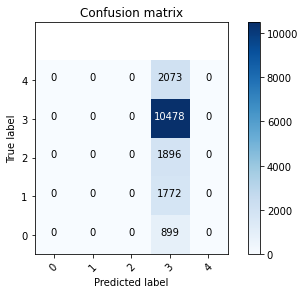

In [17]:
from evaluate import analyze_accuracy
analyze_accuracy(network, train_dataset, range(0,5))

## Accuracy on the test set

Accuracy: 0.6263145594765132


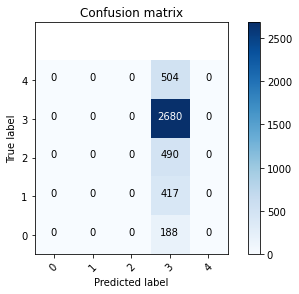

In [18]:
analyze_accuracy(network, test_dataset, range(0,5))

Seems to get stuck on a local optimum that always predicts class 3...